# Amazon Review Sentiment Analysis

In [1]:
from textblob import TextBlob
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.ml import *
from pyspark.ml.classification import *
from pyspark.ml.feature import *
from pyspark.ml.param import *
from pyspark.ml.tuning import *
from pyspark.ml.evaluation import *
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import * 
from sklearn.metrics import classification_report
from time import time
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, Row
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.ml.regression import RandomForestRegressor

## Start Spark Session

In [2]:
spark = SparkSession\
    .builder\
    .getOrCreate()

## Create schema

In [3]:
schema = StructType([
    StructField("id", StringType(), True),
    StructField("dateAdded", StringType(), True),
    StructField("dateUpdated", StringType(), True),
    StructField("name", StringType(), True),
    StructField("asins", StringType(), True),
    StructField("brand", StringType(), True),
    StructField("categories", StringType(), True),
    StructField("primaryCategories", StringType(), True),
    StructField("imageURLs", StringType(), True),
    StructField("keys", StringType(), True),
    StructField("manufacturer", StringType(), True),
    StructField("manufacturerNumber", StringType(), True),
    StructField("reviews.date", StringType(), True),
    StructField("reviews.dateAdded", StringType(), True),
    StructField("reviews.dateSeen", StringType(), True),
    StructField("reviews.doRecommend", StringType(), True),
    StructField("reviews.id", StringType(), True),
    StructField("reviews.numHelpful", StringType(), True),
    StructField("reviews.rating", IntegerType(), True),
    StructField("reviews.sourceURLs", StringType(), True),
    StructField("reviews.text", StringType(), True),
    StructField("reviews.title", StringType(), True),
    StructField("reviews.username", StringType(), True),
    StructField("sourceURLs", StringType(), True)])

## Import & Combine Data

In [4]:
raw_data1 = spark.read.format("csv")\
    .option("header", "true")\
    .option("delimiter", ",")\
    .schema(schema)\
    .csv('/Users/joanne/Documents/School/nlp_data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv')

raw_data2 = spark.read.format("csv")\
    .option("header", "true")\
    .option("delimiter", ",")\
    .schema(schema)\
    .csv("/Users/joanne/Documents/School/nlp_data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")
raw_data = raw_data1.union(raw_data2) #concatentating the second dataset to the first

for name in raw_data.schema.names:
      raw_data = raw_data.withColumnRenamed(name, name.replace('.', '_')) #cleaning up column names

In [5]:
raw_data.cache()

DataFrame[id: string, dateAdded: string, dateUpdated: string, name: string, asins: string, brand: string, categories: string, primaryCategories: string, imageURLs: string, keys: string, manufacturer: string, manufacturerNumber: string, reviews_date: string, reviews_dateAdded: string, reviews_dateSeen: string, reviews_doRecommend: string, reviews_id: string, reviews_numHelpful: string, reviews_rating: int, reviews_sourceURLs: string, reviews_text: string, reviews_title: string, reviews_username: string, sourceURLs: string]

## Sentiment Analysis

In [6]:
def textblob_udf(text):
    result = TextBlob(text).sentiment[0] #use the polarity to decide user's opinion
    if result >= 0.0:
        return 1.0
    else:
        return 0.0 
    
sentiment = udf(textblob_udf) #register udf

In [7]:
# create label column with the polarity values
reviews = raw_data.withColumn("label", sentiment(raw_data['reviews_text']))\
    .select('name','reviews_text','reviews_rating','label')

In [8]:
# convert the label data from StringType to IntegerType
reviews = reviews\
    .withColumn('label', reviews['label'].cast(IntegerType()))

In [9]:
# print schema and cache the dataframe
reviews.printSchema
reviews.cache()

DataFrame[name: string, reviews_text: string, reviews_rating: int, label: int]

## Data Exploration & Cleaning

In [10]:
reviews.select('reviews_rating').describe().show()

+-------+------------------+
|summary|    reviews_rating|
+-------+------------------+
|  count|             33332|
|   mean|4.5264610584423375|
| stddev|0.9078587637518639|
|    min|                 1|
|    max|                 5|
+-------+------------------+



In [11]:
# based on the above output, review sentiments appear relatively high. it is not uncommon to see consumers only offering reviews if they had a notably positive or negative experience with a product, or arbitrarily assigning polarized ratings (e.g 0 or 5) to products, which are issues we hope to address through removing the necessity of providing a numeric rating score. 

reviews.select('reviews_rating')\
    .groupBy('reviews_rating')\
    .count()\
    .orderBy('reviews_rating', ascending=True).show()

+--------------+-----+
|reviews_rating|count|
+--------------+-----+
|             1| 1028|
|             2|  670|
|             3| 1403|
|             4| 6856|
|             5|23375|
+--------------+-----+



In [12]:
# based on the above output, it's clear we'll need to drop some flawed data points - any ratings that are null or not between 1 and 5. 

values_list = [0, 1, 2, 3, 4, 5]
reviews = reviews.filter(reviews.reviews_rating.isin(values_list))

reviews.select('reviews_rating')\
    .groupBy('reviews_rating')\
    .count()\
    .orderBy('reviews_rating', ascending=True).show()

+--------------+-----+
|reviews_rating|count|
+--------------+-----+
|             1| 1028|
|             2|  670|
|             3| 1403|
|             4| 6856|
|             5|23375|
+--------------+-----+



In [13]:
reviews.select('label')\
    .groupBy('label')\
    .count()\
    .orderBy('label', ascending=True).show()

+-----+-----+
|label|count|
+-----+-----+
|    0| 2362|
|    1|30970|
+-----+-----+



In [14]:
# viewing matched versus mismatched review_ratings to label

reviews.select('reviews_rating','label')\
    .groupBy('reviews_rating','label')\
    .count()\
    .orderBy('reviews_rating', ascending=True)\
    .show()

+--------------+-----+-----+
|reviews_rating|label|count|
+--------------+-----+-----+
|             1|    1|  509|
|             1|    0|  519|
|             2|    0|  237|
|             2|    1|  433|
|             3|    1| 1126|
|             3|    0|  277|
|             4|    0|  392|
|             4|    1| 6464|
|             5|    1|22438|
|             5|    0|  937|
+--------------+-----+-----+



In [15]:
# as mentioned above, reviews are frequently submitted due to strong positive or negative experiences with a product. examining whether any specific products received a disproportionate share of reviews may offer additional insight into our data

display(reviews.select('name','reviews_rating').groupBy('name').count())

DataFrame[name: string, count: bigint]

In [16]:
# clearly, Amazon AAA batteries receive substantially more reviews than other products included in this dataset! it may be interesting to compare the above chart to a similar visualization displaying the average rating score given to each product.

display(reviews.select('name', 'reviews_rating').groupBy('name').avg())

DataFrame[name: string, avg(reviews_rating): double]

In [17]:
# finally, given our interest in using solely text-based response data to generate product ratings, an important consideration will be whether length of review is related to numeric rating. 

display(reviews.select('name',length('reviews_text'),'reviews_rating').groupBy('name').avg())

# consider - correlation matrix / heatmap

DataFrame[name: string, avg(length(reviews_text)): double, avg(reviews_rating): double]

## Building the Pipeline

In [18]:
# split the data - may need to change the split
train_set, test_set = reviews.randomSplit([0.7, 0.3], seed=5)

In [19]:
# features
tokenizer = RegexTokenizer(inputCol="reviews_text", outputCol="token").setPattern("\\W")
remover = StopWordsRemover(inputCol="token", outputCol="stopwordsremoved")
hashtf = HashingTF(inputCol="stopwordsremoved", outputCol='hashingTF')
idf = IDF(inputCol='hashingTF', outputCol="IDF")

# label
label_stringIdx = StringIndexer(inputCol = "label", outputCol = "StringIndexer")

# pipeline
pipeline = Pipeline(stages=[tokenizer, remover, hashtf, idf, label_stringIdx])
model = pipeline.fit(train_set)
train_df = model.transform(train_set)
test_df = model.transform(test_set)

## Logistic Regression

In [20]:
# train the logistic regression model
log_reg = LogisticRegression(labelCol="label", featuresCol="hashingTF", 
                        maxIter=10, regParam=0.01)
lr_model = log_reg.fit(train_df)

In [21]:
# run the logistic regression model
lr_predict = lr_model.transform(test_df)
lr_final = lr_predict.select("name", "reviews_rating", "prediction", "label")
lr_final\
    .groupBy('reviews_rating','prediction', 'label')\
    .count()\
    .distinct()\
    .orderBy('reviews_rating', ascending=True)\
    .show()

+--------------+----------+-----+-----+
|reviews_rating|prediction|label|count|
+--------------+----------+-----+-----+
|             1|       1.0|    0|   54|
|             1|       1.0|    1|  138|
|             1|       0.0|    0|  100|
|             1|       0.0|    1|   14|
|             2|       0.0|    1|   10|
|             2|       0.0|    0|   36|
|             2|       1.0|    1|  137|
|             2|       1.0|    0|   31|
|             3|       0.0|    0|   44|
|             3|       1.0|    1|  306|
|             3|       1.0|    0|   57|
|             3|       0.0|    1|    7|
|             4|       0.0|    0|   66|
|             4|       1.0|    1| 1946|
|             4|       0.0|    1|   14|
|             4|       1.0|    0|   55|
|             5|       0.0|    0|  124|
|             5|       1.0|    0|  148|
|             5|       0.0|    1|   45|
|             5|       1.0|    1| 6675|
+--------------+----------+-----+-----+



In [22]:
lr_correct = lr_final\
    .filter(lr_final.prediction == lr_final.label)\
    .count()

lr_total = lr_final.count()

print("Correct Prediction:", lr_correct, ", Total:", lr_total, 
      ", Accuracy Rate:", lr_correct/lr_total)

Correct Prediction: 9572 , Total: 10007 , Accuracy Rate: 0.9565304286999101


## Random Forest Model

In [23]:
#develop RF model
rf = RandomForestRegressor(labelCol="label", featuresCol="hashingTF", numTrees = 5, maxBins = 10)

In [24]:
model = rf.fit(train_df)

In [25]:
# test our model and make predictions using testing data
predictions = model.transform(test_df)
predictions.select("prediction", "label").show(5)

+------------------+-----+
|        prediction|label|
+------------------+-----+
|0.9371228876492832|    1|
|0.9689670935391433|    1|
|0.9689670935391433|    1|
|0.9535645745491106|    1|
|0.9535645745491106|    1|
+------------------+-----+
only showing top 5 rows



In [26]:
# evaluate the performance of the classifier
evaluator = BinaryClassificationEvaluator(labelCol="label",rawPredictionCol="prediction", metricName="areaUnderROC")
accuracy = evaluator.evaluate(predictions)

print("Test Error = %g" % (1.0 - accuracy))
print("Accuracy = %g " % accuracy)

#evaluator2 = BinaryClassificationEvaluator()
#print("Test Area Under ROC: " + str(evaluator2.evaluate(predictions, {evaluator2.metricName: "areaUnderROC"})))

Test Error = 0.185764
Accuracy = 0.814236 


In [27]:
#confusion matrix

from sklearn.metrics import classification_report, confusion_matrix

y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

ValueError: Classification metrics can't handle a mix of binary and continuous targets

## Visualizing the Model

In [33]:
# we can visualize our model's average ratings for each product relative to their actual average rating to get a sense of its accuracy

display(lr_final.select('name', 'prediction', 'label').groupBy('name').avg())

DataFrame[name: string, avg(prediction): double, avg(label): double]

In [34]:
# we will next convert our DataFrame to a Pandas DF for further visualization analysis

PandasDF = lr_final.toPandas()

PandasDF_raw = raw_data.select("reviews_text").toPandas()

# adding raw review text column
PandasDF['RawText'] = PandasDF_raw['reviews_text'].astype(str)

In [35]:
# we can now divide reviews into positive and negative sentiments to examine key word distribution across each, allowing us to identify specific words frequently cited in consumer reviews

Pos_Reviews = PandasDF[PandasDF['label'] == 1] #assigning reviews to positive and negative sentiment categories
Neg_Reviews = PandasDF[PandasDF['label'] == 0]

mostfrequent_pos = pd.Series(' '.join(Pos_Reviews['RawText']).lower().split()).value_counts()[:100]
mostfrequent_neg = pd.Series(' '.join(Neg_Reviews['RawText']).lower().split()).value_counts()[:100]
mostfrequent_pos_list = mostfrequent_pos.tolist() #converting to list for later filtering
mostfrequent_neg_list = mostfrequent_neg.tolist()

positive_df = pd.DataFrame([mostfrequent_pos]) #creating a positive reviews dataframe to examine
pos_df_transposed = positive_df.transpose()
pos_df_transposed.columns = ["Count"]
pos_df_transposed['Word'] = pos_df_transposed.index
pos_df_transposed[:25] #display top 25 most used words in positive reviews

,Count,Word
the,8325,the
and,6138,and
to,5820,to
i,5712,i
a,4619,a
for,4422,for
it,3861,it
is,3194,is
my,3077,my
this,2617,this


In [36]:
# clearly, stop words make up the immense bulk of words within reviews, as would be expected. we will therefore remove these stopwords using two methods: first, by directly specifying the stop words we want to remove, and second, by removing any words that are within the top 100 most used words in both positive and negative reviews. 

stopwords = ["the", "to", "and", "i", "it", "for", "a", "is", "my", "this", "with", "of", "have", "on", "that", "in", "you", "was", "but", "can",
            "as", "so", "than", "am", "does", "we", "very", "not", "she", "it", "be", "all", "they", "it.", "has", "from", "just", "an", "it's",
            "get", "at", "are", "when", "he", "she", "or", "your"]
pos_df_transposed = pos_df_transposed[~pos_df_transposed['Word'].isin(stopwords) & ~pos_df_transposed['Word'].isin(mostfrequent_neg_list)]
pos_df_transposed

,Count,Word
great,2580,great
good,1822,good
batteries,1529,batteries
love,1148,love
these,1028,these
use,958,use
tablet,937,tablet
amazon,928,amazon
price,874,price
bought,832,bought


Text(0.5, 1.0, 'Most Frequently Used Words: Positive Reviews')

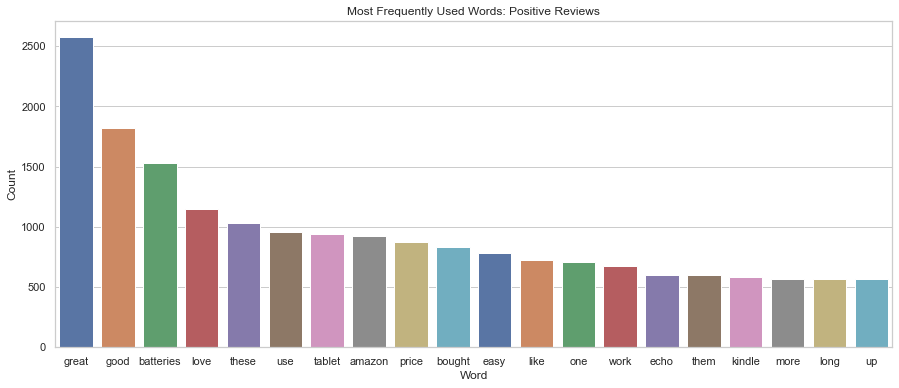

In [31]:
# finally, we can visually the top 20 most frequently used words in positive reviews

sns.set(rc={'figure.figsize':(15,6)})
sns.set_style("whitegrid")
sns.barplot(x='Word', y='Count', data=pos_df_transposed[:20], palette='deep')
plt.title("Most Frequently Used Words: Positive Reviews")

Text(0.5, 1.0, 'Most Frequently Used Words: Negative Reviews')

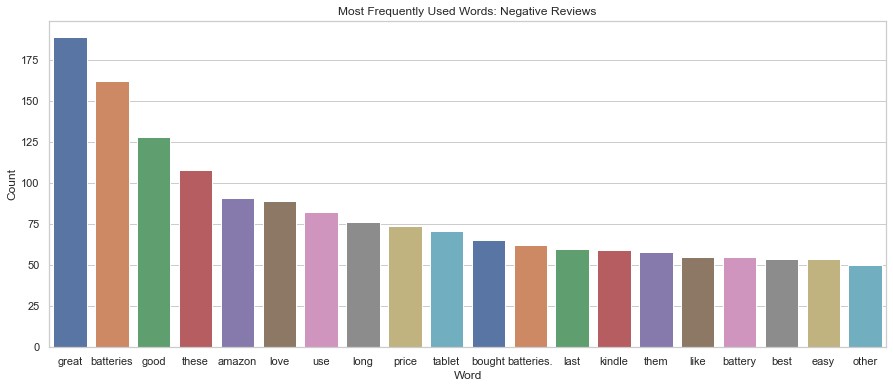

In [37]:
# we can repeat a similar process for negative reviews

negative_df = pd.DataFrame([mostfrequent_neg]) 
neg_df_transposed = negative_df.transpose()
neg_df_transposed.columns = ["Count"]
neg_df_transposed['Word'] = neg_df_transposed.index
neg_df_transposed[:25] 

neg_df_transposed = neg_df_transposed[~neg_df_transposed['Word'].isin(stopwords) & ~neg_df_transposed['Word'].isin(mostfrequent_pos_list)]
neg_df_transposed

sns.barplot(x='Word', y='Count', data=neg_df_transposed[:20], palette='deep')
plt.title("Most Frequently Used Words: Negative Reviews")